# **Análisis de pruebas PISA**
Segunda Entrega: Sábado 9 de Noviembre de 2024

**Integrantes del grupo:**
- Bas Peralta, Benjamín
- Tossolini, Lucas

# **Retomando la última entrega**

En la última entrega, definimos claramente nuestros objetivos:

* Objetivo **explicatorio**: Entender cuáles son los principales factores (socioeconómicos, de infraestructura, institucionales, regionales, etcétera) de cada alumno que influyen sobre el desempeño en las distintas materias.
* Objetivo **predictivo**: Predecir, en base a los factores antes mencionados, cuál sera el desempeño de un alumno en cada una de las materias.

El fin último de lograr estos objetivos es **implementar políticas públicas focalizadas** en diferentes sectores cuyo fin sea mejorar el nivel de desempeño de los alumnos.

Y basándonos en la documentación oficial de PISA, determinamos criterios de aprobación esepcíficos para cada área.

La primera técnica que utilizamos fue la de **regresión multivariada**, la cual nos permitió obtener algunas conclusiones de relaciones entre variables, pero descubrimos problemas que nos hicieron descartar el modelo para lograr nuestros objetivos (principalmente la no normalidad de los residuos).

Luego, aplicamos el método de clustering no jerárquico **k-means**, de donde pudimos extraer nuestra primera conclusión fuerte (a un nivel más cualitativo): la situación en el hogar (caracterizada por las variables `ESCS`, `HISEI`, `CULTPOSS` y `PARED`) es más determinante en el rendimiento de los alumnos que las características de la escuela a la que atienden (`SCHSIZE`, `DISCLIMA`, `TEACHBEHA`).

Finalmente, empleamos algoritmos de clasificación supervisada con la finalidad de poder predecir a qué alumno canalizarle ayuda para mejorar su situación en el hogar. Para esto, probamos un discriminante lineal y uno logístico, haciendo foco en la métrica de **especificidad** (que captura la noción de "ratio de verdaderos negativos"). Descubrimos que agregar más variables a la hora de hacer la clasificación mejora aunque levemente todas las métricas del modelo, y que el discriminante logístico es un poco mejor que el lineal.

# **Esta entrega**

En esta entrega, haremos uso de principalmente **algoritmos de inteligencia artificial de clasificación** con el fin de poder identificar los alumnos que desaprobarán para poder focalizar la ayuda en ellos. Tomaremos como base la clasificación con un discriminante lineal y de allí iremos complejizando cada vez más los modelos.

Es importante notar que en este punto ya nos alejamos de la capacidad de explicabilidad y nos concentramos más en el objetivo de predicción, haciendo uso de todas las variables disponibles para lograr buenas métricas. Sin emabrgo, veremos que hay modelos, como los árboles de decisión, que sí contribuyen a una interpretación más concreta y trataremos de obtener conclusiones a partir de ellos.

# **Importación de librerías**

In [ ]:
import gdown
import graphviz
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
import seaborn as sns

from scipy import stats

from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    r2_score, silhouette_score, accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, recall_score,
    make_scorer, f1_score, precision_score
)
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, scale
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.ensemble import RandomForestClassifier

from statsmodels.regression.mixed_linear_model import MixedLM

from tabulate import tabulate

# **Carga de datos**

In [ ]:
file_id = "1-2rjBgeoVG6G1ysY_dEWk8fGisE2_V44"
url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url=url, output="pisa.csv", quiet=False)
df = pd.read_csv("pisa.csv")

Downloading...
From (original): https://drive.google.com/uc?id=1-2rjBgeoVG6G1ysY_dEWk8fGisE2_V44
From (redirected): https://drive.google.com/uc?id=1-2rjBgeoVG6G1ysY_dEWk8fGisE2_V44&confirm=t&uuid=bf31363d-fe46-48c5-b18d-84a55e0208e9
To: /content/pisa.csv
100%|██████████| 179M/179M [00:01<00:00, 129MB/s]


# **Carga de codificaciones**

In [ ]:
# Codificaciones de alumnos
file_id = "1-2OJKrrVvE2PQ4xIIWe63hWuhBA-XUC2"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url=url, output="codificacion_alumnos.csv", quiet=False)
stu_encoding = pd.read_csv("codificacion_alumnos.csv")
stu_encoding.drop(columns=['Unnamed: 0'], inplace=True)

Downloading...
From: https://drive.google.com/uc?id=1-2OJKrrVvE2PQ4xIIWe63hWuhBA-XUC2
To: /content/codificacion_alumnos.csv
100%|██████████| 25.6k/25.6k [00:00<00:00, 38.7MB/s]


In [ ]:
# Codificaciones de escuelas
file_id = "1--vxX46klBFjxovIq0NSbopr8cIcV5Pf"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url=url, output="codificacion_escuelas.csv", quiet=False)
sch_encoding = pd.read_csv("codificacion_escuelas.csv")
sch_encoding.drop(columns=['Unnamed: 0'], inplace=True)

Downloading...
From: https://drive.google.com/uc?id=1--vxX46klBFjxovIq0NSbopr8cIcV5Pf
To: /content/codificacion_escuelas.csv
100%|██████████| 12.0k/12.0k [00:00<00:00, 20.9MB/s]


# **Preprocesamiento**

In [ ]:
ids = ["CNTSCHID", "CNTSTUID"]

categorical_stu = [
    "SUBNATIO",     # Región dentro de Argentina
    "GENDER",       # Género
    "IMMIG",        # Estatus inmigratorio
    "REPEAT"        # Repitencia
]
continuous_stu = [
    "AGE",          # Edad
    "PARED",        # Máximo nivel educativo alcanzado por los padres
    "HISEI",        # Estado ocupacional de los padres
    "DURECEC",      # Duración de la educación y cuidado infantil temprano
    "ESCS",         # Indice de nivel socioeconómico y cultural
    "CULTPOSS",     # Posesiones culturales
    "DISCLIMA",     # Clima disciplinario en el aula
    "EMOSUPS",      # Apoyo emocional de los padres
    "PERCOMP"       # Percepción de competencia
]

categorical_sch = [
    "PRIVATESCH",   # Escuela pública o privada
    "SCHLTYPE"      # Dependencia de la escuela
]
continuous_sch = [
    "STRATIO",      # Número de alumnos por docente
    "SCHSIZE",      # Tamaño de la escuela
    "RATCMP1",      # Disponibilidad de computadoras por estudiante
    "TOTAT",        # Número total de docentes
    "PROATCE",      # Proporción de docentes certificados
    "CREACTIV",     # Cantidad de actividades extracurriculares "creativas"
    "CLSIZE",       # Tamaño promedio de las clases
    "EDUSHORT",     # Escasez de material educativo
    "STAFFSHORT",   # Escasez de personal docente
    "STUBEHA",      # Comportamiento estudiantil
    "TEACHBEHA"     # Comportamiento de los docentes
]

continuous = continuous_stu + continuous_sch
categorical = categorical_stu + categorical_sch

target = ["MATH", "READ", "SCIE"]

keep = ids + categorical_stu + categorical_sch + continuous_stu + continuous_sch + target

In [ ]:
df_analysis = df.copy()
df_analysis = df_analysis[keep]

## **Eliminación de valores nulos**

Usamos el mismo criterio que en la Entrega 2.

Eliminamos columnas que tengan un porcentaje mayor a 10 de valores nulos:

In [ ]:
df_analysis_nan_percentage = (
    (df_analysis.isna().mean() * 100)
    .loc[lambda x: x > 0]
    .sort_values()
    .rename('NaN Percentage')
)

high_nan_percentage = df_analysis_nan_percentage[df_analysis_nan_percentage > 10]
high_nan_percentage = list(high_nan_percentage.index)

df_analysis_clean = df_analysis.drop(columns=high_nan_percentage)

Luego de esto, eliminamos todas las filas que tengan al menos un valor nulo:

In [ ]:
df_analysis_clean.dropna(axis=0, inplace=True)
df_analysis_clean.reset_index(drop=True, inplace=True)
dropped_amount = len(df_analysis) - len(df_analysis_clean)
print(
    f"Se eliminaron {dropped_amount} filas, "
    f"un {dropped_amount / len(df_analysis) * 100:.2f}%."
)

Se eliminaron 197196 filas, un 34.82%.


In [ ]:
# Variables continuas y categóricas que quedaron en el DataFrame luego de la
# limpieza de columnas
continuous_in_clean = list(set(df_analysis_clean.columns) & set(continuous))
categorical_in_clean = list(set(df_analysis_clean.columns) & set(categorical))

## **Aprobación de materias**

In [ ]:
READ_THRESH = 407
MATH_THRESH = 420
SCIE_THRESH = 409

In [ ]:
df_analysis_clean["PASSED_MATH"] = (df_analysis_clean["MATH"] >= MATH_THRESH).astype(int)
df_analysis_clean["PASSED_READ"] = (df_analysis_clean["READ"] >= READ_THRESH).astype(int)
df_analysis_clean["PASSED_SCIE"] = (df_analysis_clean["SCIE"] >= SCIE_THRESH).astype(int)

df_analysis_clean["OVERALL_PERF"] = df_analysis_clean["PASSED_MATH"] + df_analysis_clean["PASSED_READ"] + df_analysis_clean["PASSED_SCIE"]

## **DataFrame con dummies**

Para tenerlo a mano:

In [ ]:
# Creamos un nuevo DataFrame con las variables dummies
df_analysis_dummies = df_analysis_clean.copy()
dummies_columns = []
for var in categorical_in_clean:
    dummies = pd.get_dummies(df_analysis_clean[var], prefix=var).astype(int)
    dummies_columns.extend(dummies.columns)
    df_analysis_dummies = pd.concat([df_analysis_dummies, dummies], axis=1)
    df_analysis_dummies.drop(columns=[var], inplace=True)

In [ ]:
# De cada dummie, eliminamos un valor.
to_drop = [
    "SUBNATIO_Argentina",
    "GENDER_Male",
    "IMMIG_Native",
    "REPEAT_Did not repeat a <grade>",
    "PRIVATESCH_public",
    "SCHLTYPE_Public"
]
df_analysis_dummies.drop(columns=to_drop, inplace=True)
dummies_columns = list(set(dummies_columns) - set(to_drop))

# **Conjunto de entrenamiento y de test**

A lo largo de eset Colab, evaluaremos el desempeño de diferentes modelos de clasificación, y compararemos las métricas obtenidas entre ellos para poder concluir cuál es el mejor.

Ahora bien, para que esta comparación sea correcta y justa, y los resultados obtenidos en los diferentes modelos se puedan atribuir al modelo en sí y no a la distribución de los datos, se deben usar los mismos conjuntos de entrenamiento y de test para todos los modelos.

Creamos estos dos conjuntos aquí, aplicando las transformanciones necesarias (rebalanceos, normalización):

In [ ]:
# Ponemos a todas las variables como explicativas (incluso las dummies)
X = continuous_in_clean + dummies_columns
df_X = df_analysis_dummies[X]

# Nuestra variable target va a ser si el alumno aprueba Matemática o no
Y = "PASSED_MATH"
df_Y = df_analysis_dummies[Y]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    df_X, df_Y, test_size=0.3, random_state=42, stratify=df_Y
)

x_train_df = pd.DataFrame(x_train, columns=X)
x_test_df  = pd.DataFrame(x_test, columns=X)

Como ya vimos en la entrega anterior, sabemos que nuestros conjuntos están desbalanceados:

In [ ]:
y_train.value_counts() / len(y_train) * 100

,count
PASSED_MATH,
0,65.9127
1,34.0873


In [ ]:
y_test.value_counts() / len(y_test) * 100

,count
PASSED_MATH,
0,65.9122
1,34.0878


Para combatir este problema, existen varias técnicas:
* Sobremuestro de la clase minoritaria. La técnica para llevar a cabo esto se denomina SMOTE: Synthetic Minority Over-sampling Technique. Lo que se hace básicamente es generar datos sintéticos de la muestra minoritaria a partir de los datos existentes de ella.
* Submuestreo de la clase mayoritaria. Tomar una muestra aleatoria de la clase mayoritaria de forma tal que las proprociones de 0s y 1s coincidan en los conjuntos.
* Determinar cuáles son las métricas más importantes.
* Determinar diferentes pesos para las diferentes clases a la hora de computar la función de pérdida en los distintos algoritmos.

Probaremos esta última. Scikit Learn provee la función `compute_class_weight` que computa el peso $w_i$ correspondiente a cada clase $i$ de la siguiente forma:
$$
w_i = \frac{N}{C \times n_i}
$$
donde:
- $N$ es la cantidad total de muestras en el conjunto.
- $C$ es la cantidad de clases (en nuestro caso $C=2$).
- $n_i$ es la cantidad de individuos pertenecientes a la clase $i$ en la muestra.

De esta forma, se le da un mayor peso a la clase minoritaria (que para el modelo va a simbolizar "confundirse en esta clase cuesta más que confundirse en la mayoritaria").

In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
class_weights

{0: 0.7585786688748334, 1: 1.466823756529639}

Cabe notar que varias funciones incluyen el parámetro `class_weight`, que al pasarle el valor `'balanced'` hace exactamente esto.

Una buena práctica para evitar el problema de "filtración de datos" desde el conjunto de test hacia el conjunto de entrenamiento es primero separar ambos conjuntos, y normalizarlos por separado a partir de los datos del conjunto de entrenamiento.

Primero se "entrena" el normalizador en el conjunto de entrenamiento, y luego se lo aplica a este conjunto como al de test. Estandarizamos solamente sobre las continuas.

In [ ]:
scaler =  StandardScaler().fit(x_train_df[continuous_in_clean])

x_train_df[continuous_in_clean] = scaler.transform(x_train[continuous_in_clean])
x_test_df [continuous_in_clean] = scaler.transform(x_test [continuous_in_clean])

In [ ]:
x_train = x_train_df.to_numpy()
x_test  = x_test_df.to_numpy()

# **Métricas**

En la entrega anterior, también explicamos que como nuestro interés es **identificar a los alumnos que potencialmente desaprobarían**, lo que querremos lograr es **minimizar** la cantidad de **falsos positivos**, es decir la cantidad de casos en las que el modelo predice que el alumno va a aprobar (1) cuando en realidad no aprueba (0), y **maximizar la cantidad de verdaderos negativos**.

Dicho esto, la métrica a la que prestaremos más atención es la de "Recall" para valores negativos, también llamada "True Negative Rate" (TNR) o "Escpecificidad":
$$
\text{TNR} = \frac{\text{TN (True Negative)}}{\text{TN (True Negative) + FP (False Positive)}}
$$
Querremos maximizarla.

# **Funciones auxiliares**

In [ ]:
def df_correlation(df, heat_map=False, annot=False):
    """
    Calcula la matriz de correlación de un DataFrame y, opcionalmente,
    la muestra como un mapa de calor.

    Args:
        df: DataFrame del cual se calculará la correlación.
        heat_map: Si es True, se mostrará un mapa de calor de la correlación.
                  Por defecto es False.
        annot: Si es True, se mostrarán los valores de correlación en el mapa
               de calor. Solo tiene efecto si heat_map es True.
               Por defecto es False.

    Returns:
        DataFrame: Matriz de correlación del DataFrame de entrada.
    """
    correlation = df.corr()
    if heat_map:
        fig, ax = plt.subplots(figsize = (8, 6))
        fig.suptitle("Correlación simple entre variables", fontsize=18, fontweight="bold", x=0.43)
        sns.heatmap(correlation, ax=ax, cmap="twilight_shifted", annot=annot)
        plt.subplots_adjust(top=0.85)
        plt.show()
    return correlation

In [ ]:
def roc_curve_plot(y_test, y_test_pred, pos_label=1):
    log_cor_est = RocCurveDisplay.from_predictions(
        y_test, y_test_pred, pos_label=pos_label
    )
    plt.title("Curva ROC")
    plt.show()

def confusion_matrix_plot(y, y_pred):
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    plt.title("Matriz de confusión")
    plt.show()

In [ ]:
def compute_metrics(y, y_pred):
    return {
        "Accuracy":           accuracy_score(y, y_pred),
        "Recall":             recall_score(y, y_pred),
        "Specificity (TNR)":  recall_score(y, y_pred, pos_label=0),
        "F1":                 f1_score(y, y_pred),
    }

# **Regresiones**

Como dijimos en la introducción, tomaremos este modelo como base para las posteriores complejizaciones. A partir de aquí empezamos a medir métricas, siempre haciendo énfasis en el recall de la clase 0 (potencialmente desaprobados).

## **Discriminante Lineal**

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)

LinearDiscriminantAnalysis()

In [ ]:
y_train_pred = lda.predict(x_train)
y_test_pred  = lda.predict(x_test)

In [ ]:
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     72976
           1       0.71      0.61      0.66     37741

    accuracy                           0.78    110717
   macro avg       0.76      0.74      0.75    110717
weighted avg       0.78      0.78      0.78    110717



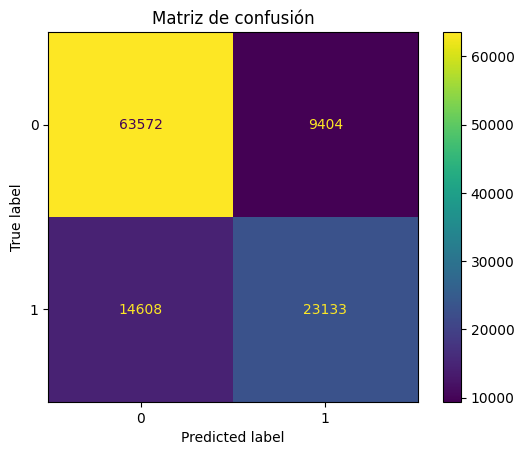

In [ ]:
confusion_matrix_plot(y_test, y_test_pred)

In [ ]:
lda_metrics = compute_metrics(y_test, y_test_pred)
lda_metrics

{'Accuracy': 0.7831227363458186,
 'Recall': 0.6129408335762169,
 'Specificity (TNR)': 0.8711357158517868,
 'F1': 0.658328353111927}

Para nuestra sorpresa, obtenemos relativamente buenas métricas, principalmente en la clase negativa. Esto es porque como ya vimos, esta es la mayoritaria. `LinearDiscriminantAnalysis` no deja establecer los pesos a cada clase, como veremos que sí lo dejan otros algoritmos.

Observemos un poco entonces los coeficientes de esta recta para ver si podemos descubrir cuáles son las variables más importantes a la hora de hacer la clasificación:

In [ ]:
weights = lda.coef_[0]

var_weight = {}
for var, weight in zip(x_train_df.columns, weights):
    var_weight[var] = round(weight, 5)

var_weight_df = pd.DataFrame(var_weight, index=["Weight"]).T.sort_values(by="Weight", ascending=False)
var_weight_df[abs(var_weight_df['Weight']) >= 0.8]

,Weight
SCHLTYPE_Private Independent,1.0814
ESCS,0.9071
SUBNATIO_Argentina: Ciudad Autnoma de Buenos,0.8876
REPEAT_Repeated a <grade>,-1.2012


Como venimos reconfirmando hasta ahora, las variables más influyentes en la clasificación con discriminante lineal son:
* El tipo de escuela (pública o privada)
* El nivel socioecónomico de los padres
* Si pertenece o no a la Ciudad Autonoma de Buenos Aires
* Repitencia

## **Regresión Logística**

In [ ]:
logreg = LogisticRegression(
    fit_intercept=True,
    class_weight='balanced',
    max_iter=10000
)

In [ ]:
logreg.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [ ]:
y_train_pred = logreg.predict(x_train)
y_test_pred  = logreg.predict(x_test)

In [ ]:
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80     72976
           1       0.61      0.76      0.68     37741

    accuracy                           0.75    110717
   macro avg       0.73      0.75      0.74    110717
weighted avg       0.77      0.75      0.76    110717



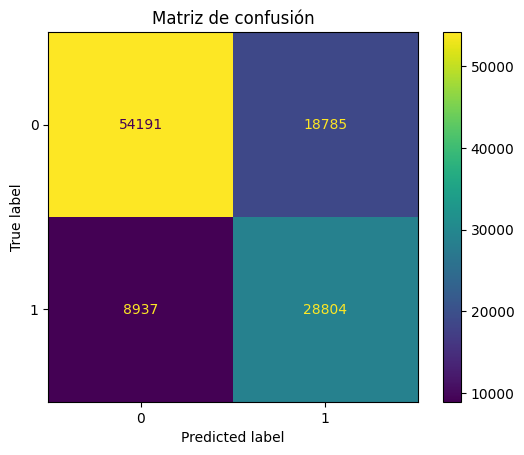

In [ ]:
confusion_matrix_plot(y_test, y_test_pred)

In [ ]:
logreg_metrics = compute_metrics(y_test, y_test_pred)
logreg_metrics

{'Accuracy': 0.7496138804338991,
 'Recall': 0.7632018229511671,
 'Specificity (TNR)': 0.7425866038149529,
 'F1': 0.6751201218797609}

En la métrica que nos interesa, obtuvimos un porcentaje del 74%, y en la precisión global del modelo obtuvimos un porcentaje del 75%.

Las métricas en general son similares a las obtenidas con el Discriminante Lineal. Como en la función `LogisticRegression` podemos agregar el parámetro `class_weight='balanced'`, obtenemos mejores resultados para la clase 1, y levemente peores para la clase 0, producto del balanceo por medio de pesos para las clases.

# **KNN: K vecinos más cercanos**

In [ ]:
# No correr esta celda. Lleva mucho tiempo.
train_accus = []
test_accus  = []

train_tnrs   = []
test_tnrs    = []

n_neighbors = np.arange(3,15,2)

for n in n_neighbors:
    neigh = KNeighborsClassifier(n_neighbors=n)

    neigh.fit(x_train, y_train)

    y_train_pred = neigh.predict(x_train)
    y_test_pred  = neigh.predict(x_test)

    # Calcular las métricas
    train_accu = accuracy_score(y_train, y_train_pred)
    test_accu  = accuracy_score(y_test, y_test_pred)
    train_accus.append(train_accu)
    test_accus.append(test_accu)

    train_tnr = recall_score(y_train, y_train_pred, pos_label=0)
    test_tnr  = recall_score(y_test, y_test_pred, pos_label=0)
    train_tnrs.append(train_tnr)
    test_tnrs.append(test_tnr)

    print(f"Número de vecinos = {n}")
    print(f"  train_accu: {train_accu:.5f}, test_accu: {test_accu:.5f}")
    print(f"  train_tnr : {train_tnr:.5f} , test_tnr : {test_tnr :.5f}")
    print()

Número de vecinos = 3
  train_accu: 0.99999, test_accu: 0.99991
  train_tnr : 1.00000 , test_tnr : 1.00000

Número de vecinos = 5
  train_accu: 0.99994, test_accu: 0.99962
  train_tnr : 0.99999 , test_tnr : 0.99992

Número de vecinos = 7
  train_accu: 0.99978, test_accu: 0.99911
  train_tnr : 0.99992 , test_tnr : 0.99975

Número de vecinos = 9
  train_accu: 0.99911, test_accu: 0.99772
  train_tnr : 0.99927 , test_tnr : 0.99844

Número de vecinos = 11
  train_accu: 0.99789, test_accu: 0.99589
  train_tnr : 0.99841 , test_tnr : 0.99726



In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].plot(n_neighbors, train_tnrs, color="blue", label="Train")
axes[0].plot(n_neighbors, test_tnrs,  color="red",  label="Test")
axes[0].set_xlabel("Profundidad máxima")
axes[0].set_xticks(n_neighbors[::2])
axes[0].set_ylabel("TNR")
axes[0].grid()
axes[0].legend()

axes[1].plot(n_neighbors, train_accus, color="blue", label="Train")
axes[1].plot(n_neighbors, test_accus,  color="red",  label="Test")
axes[1].legend()
axes[1].set_xlabel("Profundidad máxima")
axes[1].set_xticks(n_neighbors[::2])
axes[1].set_ylabel("Precisión global")
axes[1].grid()
axes[1].legend()

plt.show()

Vemos que tomando 3 vecinos obtenemos métricas perfectas!

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(x_train, y_train)

y_train_pred = neigh.predict(x_train)
y_test_pred  = neigh.predict(x_test)

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

knn_metrics = compute_metrics(y_test, y_test_pred)
print(knn_metrics)

# **Árboles de decisión**

El árbol de decisión es un algoritmo muy potente, y lo más importante es que es de "caja blanca", es decir se puede seguir el "recorrido" que hace un individuo sobre las separaciones del árbol para así poder entender cómo fue que se llegó a la predicción de su categoría.

Lo utilizaremos para retornar, de momento, a nuestro objetivo explicativo.

In [ ]:
# hyperparams = {
#     'max_depth':      np.arange(2, 15),
#     'max_leaf_nodes': np.arange(2,30,2),
#     'criterion':      ['gini', 'entropy']
# }

In [ ]:
# recall_class_0_scorer = make_scorer(recall_score, pos_label=0)
# dtc_GS = GridSearchCV(
#     dtc,
#     hyperparams,
#     scoring=recall_class_0_scorer,
#     n_jobs=-1,
#     cv=5
# )

# dtc_GS.fit(x_train, y_train)

In [ ]:
# print(f"Best parameters: {dtc_GS.best_params_}")
# print(f"Best recall for class 0: {dtc_GS.best_score_}")

# # Evaluate the best model on the test set
# best_model = dtc_GS.best_estimator_
# y_pred = best_model.predict(x_test)

# # Calculate recall for class 0 on the test set
# recall_class_0_test = recall_score(y_test, y_pred, pos_label=0)
# print("Test recall for class 0:", recall_class_0_test)

## **Profundidad máxima**

In [ ]:
train_accus = []
test_accus  = []

train_tnrs = []
test_tnrs  = []

max_depths = np.arange(2, 30)

for max_depth in max_depths:
    model = DecisionTreeClassifier(
        max_depth=max_depth, criterion='entropy', random_state=42, class_weight='balanced'
    )

    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    y_test_pred  = model.predict(x_test)

    train_accu = accuracy_score(y_train, y_train_pred)
    test_accu  = accuracy_score(y_test, y_test_pred)
    train_accus.append(train_accu)
    test_accus.append(test_accu)

    train_tnr = recall_score(y_train, y_train_pred, pos_label=0)
    test_tnr  = recall_score(y_test, y_test_pred, pos_label=0)
    train_tnrs.append(train_tnr)
    test_tnrs.append(test_tnr)

    print(f"Max Depth = {max_depth}")
    print(f"  train_accu: {train_accu:.5f}, test_accu: {test_accu:.5f}")
    print(f"  train_tnr : {train_tnr:.5f} , test_tnr : {test_tnr :.5f}")
    print()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].plot(max_depths, train_tnrs, color="blue", label="Train")
axes[0].plot(max_depths, test_tnrs,  color="red",  label="Test")
axes[0].set_xlabel("Profundidad máxima")
axes[0].set_xticks(max_depths[::2])
axes[0].set_ylabel("TNR")
axes[0].grid()
axes[0].legend()

axes[1].plot(max_depths, train_accus, color="blue", label="Train")
axes[1].plot(max_depths, test_accus,  color="red",  label="Test")
axes[1].legend()
axes[1].set_xlabel("Profundidad máxima")
axes[1].set_xticks(max_depths[::2])
axes[1].set_ylabel("Precisión global")
axes[1].grid()
axes[1].legend()

plt.show()

Claramente, mientras mayor profundidad le demos al árbol, mejores métricas vamos a obtener ya que le damos mayor "libertad" para elegir el camino de cada instancia. Sin embargo, como vamos a utilizar esta técnica para lograr una mayor comprensión de los drivers del desempeño, acotaremos la profundidad para obtener un árbol que resulte inteligible.

Viendo ambos gráficos, optamos por una profundidad máxima de 16, en donde ambas métricas están alrededor del 90%.

## **Número máximo de hojas**

In [ ]:
train_accus = []
test_accus  = []

train_tnrs = []
test_tnrs  = []

max_leaves = np.arange(2, 30, 2)

for l in max_leaves:
    model = DecisionTreeClassifier(
        max_depth=16, max_leaf_nodes=l, criterion='entropy', random_state=42, class_weight='balanced'
    )

    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    y_test_pred  = model.predict(x_test)

    train_accu = accuracy_score(y_train, y_train_pred)
    test_accu  = accuracy_score(y_test, y_test_pred)
    train_accus.append(train_accu)
    test_accus.append(test_accu)

    train_tnr = recall_score(y_train, y_train_pred, pos_label=0)
    test_tnr  = recall_score(y_test, y_test_pred, pos_label=0)
    train_tnrs.append(train_tnr)
    test_tnrs.append(test_tnr)

    print(f"Max Leaf Nodes = {l}")
    print(f"  train_accu: {train_accu:.5f}, test_accu: {test_accu:.5f}")
    print(f"  train_tnr : {train_tnr:.5f} , test_tnr : {test_tnr :.5f}")
    print()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].plot(max_leaves, train_tnrs, color="blue", label="Train")
axes[0].plot(max_leaves, test_tnrs,  color="red",  label="Test")
axes[0].set_xlabel("Máxima cantidad de hojas")
axes[0].set_xticks(max_leaves)
axes[0].set_ylabel("TNR")
axes[0].grid()
axes[0].legend()

axes[1].plot(max_leaves, train_accus, color="blue", label="Train")
axes[1].plot(max_leaves, test_accus,  color="red",  label="Test")
axes[1].legend()
axes[1].set_xlabel("Máxima cantidad de hojas")
axes[1].set_xticks(max_leaves)
axes[1].set_ylabel("Precisión global")
axes[1].grid()
axes[1].legend()

plt.show()

Nuevamente, analizando ambos gráficos y prestando especial atención al de TNR, elegimos un cantidad máxima de hojas de 16.

## **Arbol con parámetros elegidos**

In [ ]:
dtc = DecisionTreeClassifier(
    max_depth=16, max_leaf_nodes=16, criterion='entropy', random_state=42, class_weight='balanced'
)
dtc.fit(x_train, y_train)

In [ ]:
print("Propiedades del árbol entrenado:")
print(f"Profundidad : {dtc.get_depth()}")
print(f"Cantidad de hojas: {dtc.get_n_leaves()}")

In [ ]:
y_train_pred = dtc.predict(x_train)
y_test_pred  = dtc.predict(x_test)

In [ ]:
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

In [ ]:
dtc_metrics = compute_metrics(y_test, y_test_pred)
dtc_metrics

Volvemos a obtener en general mejores métricas para la clase 0. En general, son todas similares a las de la regresión logística.

A pesar de no estar tan conformes con las métricas obtenidas, veamos el árbol que se termina formando para poder identificar cuáles son los factores más relevantes.

In [ ]:
# Print tree structure with feature names
tree_text = export_text(dtc, feature_names=list(x_train_df.columns))
print(tree_text)

In [ ]:
x_columns_clean = x_train_df.columns.tolist().copy()
repeated_grade_index = x_columns_clean.index('REPEAT_Repeated a <grade>')
x_columns_clean[repeated_grade_index] = 'REPEAT'

dot_data = export_graphviz(
    dtc,
    out_file=None,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=x_columns_clean,
    class_names=['Desaprueba', 'Aprueba'],
)

graph = graphviz.Source(dot_data, format="png")
graph

In [ ]:
graph.render(filename="tree_graph", cleanup=True)

Los árboles de decisión nos permiten ilustrar claramente los efectos primordiales de las variables sobre el resultado de los alumnos. El primer gran separador es el nivel socioeconómico de los padres, `ESCS`.

Luego, para los alumnos que tienen un peor `ESCS`, aparece la repitencia como un factor determinante, meintras que para los que tienen un mejor `ESCS`, el tipo de escuela aparece como el principal determinante.

Es interesante notar que la variable `STUBEHA`, que representa el compotamiento del alumno también aparece como una característica importante, lo cual no lo habíamos identificado hasta el momento.

Poder seguir el camino que hace el árbol al hacer una predicción permite definir claramente cuáles son las condiciones que llevan a las mayores probabilildades de desaprobación.

# **Clasificación con Support Vector Machine (SVM)**

In [ ]:
svm = LinearSVC(
    class_weight='balanced',
    random_state=42,
    fit_intercept=False,         # Ya estandarizamos los datos
    max_iter=1000
)
svm.get_params()

In [ ]:
svm.fit(x_train, y_train)

In [ ]:
y_train_pred = svm.predict(x_train)
y_test_pred  = svm.predict(x_test)

In [ ]:
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

In [ ]:
confusion_matrix_plot(y_test, y_test_pred)

In [ ]:
svm_metrics = compute_metrics(y_test, y_test_pred)
svm_metrics

# **Redes Neuronales**

En las entregas anteriores se detectaton diversas características del alumno y las escuelas que influyen en el rendimiento logrado.

Varios atributos resultaron particularmente interesantes, ya sea proque su impacto fue notorio o porque resultan facilmente identificables para la aplicación de una política pública dirigida a la mejora académica.

En este sentido, encontramos aspectos cómo el tipo de escuela y la geografía. Los análisis exploratorios y confirmatorios demostraron que el tipo de escuela (público/privada) y la región donde se realizó la encuesta impactan en el resultado. A su vez, la regresión multivariada (aunque no nos sirvió a los fines preditivos), mostró que los alumnos pertenecientes a escuelas públicas y/o que viven en Tucumán tienen un desempeño más bajo que el resto. Este debería ser un primer _driver_ para decidir dónde actuar.

Sin embargo, conforme el análisis fue avanzando, se detectó el efecto de otras variables menos evidentes. Las sospechas sobre el impacto de la situación del alumno en el hogar o la situación en la escuela surgieron de los análisis previos (regresiones individuales y multivariadas), sin embargo, no quedaban claros los efectos. Por ese motivo, se decidió por clusterizas a los alumnos según estas características.

Hecho este trabajo, se encontraron claros grupos extremos en la cuestión hogareña (no tanto en la situación de la escuela), que tenían desempeños opuestos en las tres materia analizadas (matemática, lectura y ciencia). Esto nos llevó a considerar a la situación en el hogar como un aspecto conveniente a ser atacado por la polítcia.

Teniendo en mente esas características fácilmente identificables (tipo de escuela, geografía y situación en el hogar), restaba identificar a los alumnos que tendrían un mal desempeño para dirigir hacia ellos la asistencia. Para esto, se recurrió, primero, a modelos de clasificación que no dieron resultados del todo satisfactorios.

Por ese motivo, se recurre ahora a redes neuronales para intentar predecir más acertadamente el resultado de los niños en las evaluaciones

## **Perceptrón simple**

Explicar las diferencia con el Linear Discriminant Analysis que hicimos en la entrega 2

In [ ]:
simple_perceptron = Perceptron(
    fit_intercept=False,       # Ya estandarizamos los datos
    shuffle=True,              # Mezclar los datos antes de cada época
    max_iter=10000,            # Epocas
    n_iter_no_change=15,       # Número de iteraciones a esperar antes de hacer el early stopping
    random_state=1,            # Se usa cuando se mezclan los datos
    class_weight="balanced",   # Used for adjusting weights when data is imbalanced
)
simple_perceptron.fit(x_train, y_train)

In [ ]:
y_train_pred = simple_perceptron.predict(x_train)
y_test_pred  = simple_perceptron.predict(x_test)

In [ ]:
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

In [ ]:
confusion_matrix_plot(y_test, y_test_pred)

In [ ]:
simple_perceptron_metrics = compute_metrics(y_test, y_test_pred)
simple_perceptron_metrics

## **Perceptrón multicapa**

In [ ]:
mlp = MLPClassifier(
    early_stopping=True,
    max_iter=200,
    hidden_layer_sizes=(30,30,10),
    random_state=42
)
mlp.get_params()

In [ ]:
mlp.fit(x_train, y_train)

In [ ]:
y_train_pred = mlp.predict(x_train)
y_test_pred  = mlp.predict(x_test)

In [ ]:
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

In [ ]:
confusion_matrix_plot(y_test, y_test_pred)

In [ ]:
mlp_metrics = compute_metrics(y_test, y_test_pred)
mlp_metrics

# **Conclusiones**

Analicemos las métricas que obtuvimos en los diferentes modelos:

In [ ]:
models_metrics = {
    "Discriminante Lineal": lda_metrics,
    "Regresión Logística": logreg_metrics,
    "KNN": knn_metrics,
    "Árboles de decisión": dtc_metrics,
    "SVM": svm_metrics,
    "Perceptrón Simple": simple_perceptron_metrics,
    "Perceptrón Multicapa": mlp_metrics,
}

In [ ]:
metrics_df = pd.DataFrame(models_metrics).T
metrics_df

Si bien tanto el algoritmo de K vecinos más cercanos como el de perceptrón multicapa nos dan métricas muy altas, decidimos tomar como modelo definitivo el perceptrón multicapa ya que es relativamente rápido de entrenar y las predicciones se hacen al instante. En cambio, en el K vecinos más cercanos, cada predicción lleva mucho tiempo.

El método evolutivo  y fuertemente analítico de este trabajo permitió llegar a un modelo predictivo con alta precisión, sin perder potencia explicativa (la que hubiera estado ausente si se hubiera recurrido de inmediato a modelos “oscuros”, como una red neuronal).

Los modelos predictivos de la última sección sirven para identificar a los alumnos que potencialmente desaprobarían.

Se confirmó que tanto “la situación en el hogar” como “en la escuela” tienen un impacto en el resultado. Sin embargo, a los fines de la política pública (foco de este análisis), resulta más conveniente atacar lo más evidente: la “situación en el hogar”.
